# Assignment 5: Block Matching and Harris Corner Detection
## Ex. 5.1 Dense Optical Flow by Block Matching
* implement the block matching method as shown in the lecture
* take two frames from the datasets "lane_detection" or "copter_flight" with variable distances in time (1, 2, x) and compute the vector flow field
* display a subset of flow vectors on the gray-value version of the first image, by drawing a respective line. adjust the grid density such that not too many vectors overlap (**RESULT**)

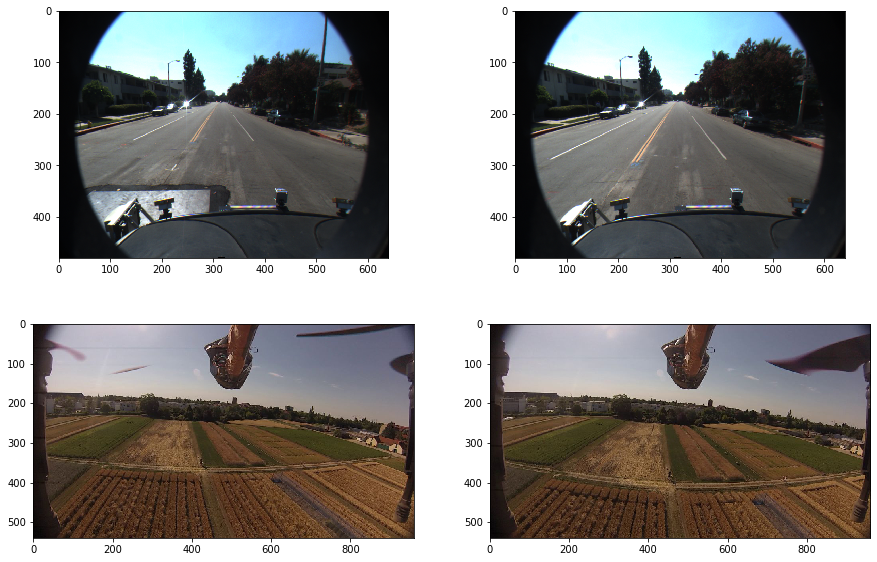

In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
import numpy as np

# Chose other images if you like
lane1 = io.imread('images/lane_detection/f00000.png')
lane2 = io.imread('images/lane_detection/f00001.png')

# Footage from our Neurocopter project:
# http://berlinbiorobotics.blog/projects/neurocopter/
copter1 = io.imread('images/copter_flight/frame050.jpg')
copter2 = io.imread('images/copter_flight/frame052.jpg') 

fig = plt.figure(figsize=(15, 10))
ax11 = plt.subplot(2, 2, 1)
ax12 = plt.subplot(2, 2, 2)
ax21 = plt.subplot(2, 2, 3)
ax22 = plt.subplot(2, 2, 4)

ax11.imshow(lane1)
ax12.imshow(lane2)

ax21.imshow(copter1)
ax22.imshow(copter2)

In [48]:
from skimage import io, data, feature, color
import numpy as np


"""
for each pixel 𝑥, 𝑦 in 𝐼
    iterate over all Δ𝑥, Δ𝑦 in a window 𝑊 around 𝑥, 𝑦
        compute the (windowed) SSD between 
        𝐼_𝑡(𝑥,𝑦) and 𝐼_{𝑡+1}(𝑥+Δ𝑥,𝑦+Δ𝑦)
    store the flow vector Δ𝑥, Δ𝑦 for the position 𝑥, 𝑦
"""


def get_window_coords(x, y, window_size, shape=None, clip=None, as_tuple=False):
    """
    :param window_size: (height, width) values should be odd
    
    Returned values are exclusive so ready for slicing.
    """
    
    delta_y, delta_x = window_size // 2
    if clip:
        clip_y, clip_x = clip
    else:
        assert shape, "'shape' argument required, when 'clip' is not given"
        height, width = shape
        clip_y = (0, height)
        clip_x = (0, width)
    y_min, y_max = np.clip(np.array([y - delta_y, y + delta_y + 1]), *clip_y)
    x_min, x_max = np.clip(np.array([x - delta_x, x + delta_x + 1]), *clip_x)
    if as_tuple:
        # No 'step' value here...
        return ((y_min, y_max), (x_min, x_max))
    return np.s_[y_min:y_max, x_min:x_max]
    

def get_window(image, x, y, window_size, shape):
    return image[get_window_coords(x, y, window_size, shape)]


def calc_ssd(image, x, y, dx, dy, block_size, shape):
    print(x, y, dx, dy)
    # For the examle comments 'Ex' below we assume:
    # (x,y) = (2,5); (dx,dy) = (2,-3); block_size = 3; shape=(7,7)
    
    block = get_window(image, x, y, block_size, shape)
    # Ex: (tx,ty) = (4,2)
    ty, tx = y + dy, x + dx
    shifted_block = get_window(image, tx, ty, block_size, shape)
    
#     # Idea:
#     # Minimize the amount of pixels that need to be rolled
#     # by rolling only the part of the image that is affected
#     # by the given 'dx' and 'dy'.
    
#     # Ex:
#     # 0 0 0 0 0 0 0
#     # 0 0 0 0 0 0 0
#     # 0 0 0 0 0 0 0
#     # 0 0 0 0 0 0 0
#     # 0 1 1 1 0 0 0
#     # 0 1 1 1 0 0 0
#     # 0 1 1 1 0 0 0
#     (
#         (y_min, y_max),
#         (x_min, x_max)
#     ) = get_window_coords(x, y, block_size, shape, as_tuple=True)
    
#     # Ex:
#     # 0 0 0 0 0 0 0
#     # 0 0 0 1 1 1 0
#     # 0 0 0 1 1 1 0
#     # 0 0 0 1 1 1 0
#     # 0 0 0 0 0 0 0
#     # 0 0 0 0 0 0 0
#     # 0 0 0 0 0 0 0
#     shifted_coords = (
#         (shifted_y_min, shifted_y_max), 
#         (shifted_x_min, shifted_x_max)
#     ) = get_window_coords(tx, ty, block_size, shape, as_tuple=True)
#     # Ex:
#     # (1,7), (1,7)
#     spanned_area_coords = (
#         (min(y_min, shifted_y_min), max(y_max, shifted_y_max)),
#         (min(x_min, shifted_x_min), max(x_max, shifted_x_max))
#     )
#     spanned_area_top, spanned_area_left = spanned_area_coords[0][0], spanned_area_coords[1][0]
#     # Ex:
#     # 0 0 0 0 0 0 0
#     # 0 x x x x x 0
#     # 0 x x x x x 0
#     # 0 x x x x x 0
#     # 0 1 1 1 x x 0
#     # 0 1 1 1 x x 0
#     # 0 1 1 1 x x 0
#     spanned_area = image[
#         spanned_area_top:spanned_area_coords[0][1],
#         spanned_area_left:spanned_area_coords[1][1]
#     ]
#     # Ex:
#     # 0 0 0 0 0 0 0
#     # 0 x x 1 1 1 0
#     # 0 x x 1 1 1 0
#     # 0 x x 1 1 1 0
#     # 0 x x x x x 0
#     # 0 x x x x x 0
#     # 0 x x x x x 0
#     rolled = np.roll(spanned_area, (dy, dx), (0, 1))
#     # Ex: shifted blocks coords would be (ymin=1, ymax=4, xmin=3, xmax=6) but relative to
#     #     the rolled, spanned area it's now (ymin=0, ymax=3, xmin=2, xmax=5).
#     translated_shifted_coords = (
#         np.array(shifted_coords) 
#         - np.array([[spanned_area_top, spanned_area_left]]).T
#     )
# #     print(translated_shifted_coords)
#     shifted_block = rolled[
#         translated_shifted_coords[0,0]:translated_shifted_coords[0,1],
#         translated_shifted_coords[1,0]:translated_shifted_coords[1,1]
#     ]
    print(np.sum(np.square(block - shifted_block)))
    return np.sum(np.square(block - shifted_block))


def calc_flow(image, x, y, block_size, search_window, shape):
    flow_vector = None
    min_ssd = None
    ref = np.array([x, y])
    
    height, width = shape
    pad_y, pad_x = block_size // 2
    clip = ((pad_y, height - pad_y), (pad_x, width - pad_x))
#     print('sw', search_window.shape, clip)
    (y_min, y_max), (x_min, x_max) = get_window_coords(x, y, 
                                                       np.array(search_window.shape), 
                                                       clip=clip, 
                                                       as_tuple=True)
#     print(y_min, y_max, x_min, x_max)
#     # Notation like in the lecture.
#     I = lambda x, y: image[y, x]
    for yi in range(y_min, y_max):
        for xi in range(x_min, x_max):
            dx, dy = np.array([xi, yi]) - ref
            if dx == 0 and dy == 0:
                continue

            ssd = calc_ssd(image, x, y, dx, dy, block_size, shape)
            if min_ssd is None or ssd < min_ssd:
                min_ssd = ssd
                flow_vector = np.array([dx, dy])
    return flow_vector


store = {}
block_size = np.array([11, 11])
search_window_size = np.array([100, 100])
pois = [(5, 5)]
sequence = [color.rgb2gray(image) for image in [lane1, lane2]]
shape = sequence[0].shape
print(shape)
for t, image in enumerate(sequence):
    if t == 0:
        continue
        
    im_h, im_w = image.shape
    pad_y, pad_x = block_size // 2
#     for y in range(pad_y, im_h - pad_y, 80):
#         for x in range(pad_x, im_w - pad_x, 80):
    for y in [256]:
        for x in [260]:
            print(f'at x={x}, y={y}. finding flow vector...')
#             block = get_window(sequence[t - 1], x, y, block_size, shape)
            search_window = get_window(image, x, y, search_window_size, shape)
            flow_vector = calc_flow(image, x, y, block_size, search_window, shape)
            store[(x, y)] = flow_vector
#             if x > 20 or y > 20:
#                 break
#     min_ssd = None

print(store)

None

(480, 640)
at x=260, y=256. finding flow vector...
260 256 -50 -50
6.421848494748482
260 256 -49 -50
5.941802193868666
260 256 -48 -50
5.440859827936639
260 256 -47 -50
4.908965529124644
260 256 -46 -50
4.378199730926567
260 256 -45 -50
3.862566334299116
260 256 -44 -50
3.503882231065129
260 256 -43 -50
3.213230070507497
260 256 -42 -50
2.951994230750326
260 256 -41 -50
2.6811486594386773
260 256 -40 -50
2.3606343400958094
260 256 -39 -50
2.134216830875048
260 256 -38 -50
2.147105424036601
260 256 -37 -50
2.180495318717724
260 256 -36 -50
2.2268560938283737
260 256 -35 -50
2.25683334594925
260 256 -34 -50
2.3285972671613995
260 256 -33 -50
2.3749701647063435
260 256 -32 -50
2.4158481103546325
260 256 -31 -50
2.399113496913341
260 256 -30 -50
2.3770224408639753
260 256 -29 -50
2.3302544395164935
260 256 -28 -50
2.2506319327266437
260 256 -27 -50
2.095155496453671
260 256 -26 -50
1.9420162171841595
260 256 -25 -50
1.8487348520232212
260 256 -24 -50
1.8386125448184545
260 256 -23 -50
1.86

2.7243654524346015
260 256 35 -47
2.2176188850309875
260 256 36 -47
2.0230211888010765
260 256 37 -47
2.137365675139869
260 256 38 -47
2.4130094050166857
260 256 39 -47
2.6366006095698578
260 256 40 -47
2.685533960378162
260 256 41 -47
2.727770732770011
260 256 42 -47
2.802752451853133
260 256 43 -47
2.8993089607604765
260 256 44 -47
3.0082709697742405
260 256 45 -47
3.0862198337654747
260 256 46 -47
3.1451597484465967
260 256 47 -47
3.199337519351787
260 256 48 -47
3.2443287907504805
260 256 49 -47
3.25129384586882
260 256 50 -47
3.2660142614708185
260 256 -50 -46
1.9667956534445212
260 256 -49 -46
1.9754380864699732
260 256 -48 -46
1.957015005206459
260 256 -47 -46
1.9301833635224914
260 256 -46 -46
1.9090152592807383
260 256 -45 -46
1.892934303373779
260 256 -44 -46
1.9460131065770088
260 256 -43 -46
2.0391017028044596
260 256 -42 -46
2.198765378270358
260 256 -41 -46
2.3477082487183396
260 256 -40 -46
2.5070276775323337
260 256 -39 -46
2.6708251736516724
260 256 -38 -46
2.868318850

2.889204100831834
260 256 -40 -43
2.797074063054671
260 256 -39 -43
2.6894266893516345
260 256 -38 -43
2.6224887805477897
260 256 -37 -43
2.649564517128489
260 256 -36 -43
2.7126990064026146
260 256 -35 -43
2.7562968765933102
260 256 -34 -43
2.785033249932334
260 256 -33 -43
2.7390393268667435
260 256 -32 -43
2.5993080307660126
260 256 -31 -43
2.4865234832819687
260 256 -30 -43
2.4448681652938102
260 256 -29 -43
2.475345301346405
260 256 -28 -43
2.466002717876201
260 256 -27 -43
2.3018684071038833
260 256 -26 -43
2.054036175770396
260 256 -25 -43
1.8029454885851595
260 256 -24 -43
1.6884936465516336
260 256 -23 -43
1.6673721054703574
260 256 -22 -43
1.6738967029585547
260 256 -21 -43
1.7021867012324492
260 256 -20 -43
1.7309340471615533
260 256 -19 -43
1.7612486542985004
260 256 -18 -43
1.7726962038231449
260 256 -17 -43
1.755956548859054
260 256 -16 -43
1.7258520611267973
260 256 -15 -43
1.6743676171224915
260 256 -14 -43
1.6323320952395233
260 256 -13 -43
1.5887717517900806
260 256 -

260 256 -42 -39
2.7880601388779698
260 256 -41 -39
2.8095165391540178
260 256 -40 -39
2.740214521280123
260 256 -39 -39
2.6485514611063437
260 256 -38 -39
2.6235798859709347
260 256 -37 -39
2.5364975014511346
260 256 -36 -39
2.4599335253940793
260 256 -35 -39
2.3106316102183775
260 256 -34 -39
2.248615662105498
260 256 -33 -39
2.2944269193491733
260 256 -32 -39
2.3161872050617447
260 256 -31 -39
2.1682832282691273
260 256 -30 -39
1.9224520009537873
260 256 -29 -39
1.765440349433449
260 256 -28 -39
1.8016913284026146
260 256 -27 -39
1.81349304761138
260 256 -26 -39
1.863110588806459
260 256 -25 -39
1.7650213408473665
260 256 -24 -39
1.701812359868666
260 256 -23 -39
1.6787678844372165
260 256 -22 -39
1.6282790948753552
260 256 -21 -39
1.5872633475294113
260 256 -20 -39
1.5979924072081504
260 256 -19 -39
1.6240830270969626
260 256 -18 -39
1.6085732245047288
260 256 -17 -39
1.5859118967973853
260 256 -16 -39
1.571607451431603
260 256 -15 -39
1.5922609608653593
260 256 -14 -39
1.6246327360

1.7875789488925795
260 256 -10 -35
1.8172635316322951
260 256 -9 -35
1.823576674612072
260 256 -8 -35
1.794776696497501
260 256 -7 -35
1.7939438630300653
260 256 -6 -35
1.7851160187277197
260 256 -5 -35
1.79793646691534
260 256 -4 -35
1.797472792592695
260 256 -3 -35
1.7591722489094963
260 256 -2 -35
1.7290910647472513
260 256 -1 -35
1.6864427179677048
260 256 0 -35
1.66803061813441
260 256 1 -35
1.637858937658439
260 256 2 -35
1.6153922991309495
260 256 3 -35
1.6076143424847367
260 256 4 -35
1.6201727914960398
260 256 5 -35
1.6045603368027677
260 256 6 -35
1.610888317659669
260 256 7 -35
1.6115028282049977
260 256 8 -35
1.6364999973439447
260 256 9 -35
1.7095619667031143
260 256 10 -35
1.8249036630106883
260 256 11 -35
2.030838129245521
260 256 12 -35
2.2853670055590922
260 256 13 -35
2.574835025732872
260 256 14 -35
2.947077401169858
260 256 15 -35
3.3409854214277583
260 256 16 -35
3.5487832752936566
260 256 17 -35
3.2404875343635524
260 256 18 -35
2.479414136933641
260 256 19 -35
1.

260 256 28 -31
2.980710587294733
260 256 29 -31
3.0679764759415606
260 256 30 -31
3.1445953060741254
260 256 31 -31
3.251403727782238
260 256 32 -31
3.355486596619608
260 256 33 -31
3.432449573339485
260 256 34 -31
3.496620395973395
260 256 35 -31
3.5654351282802
260 256 36 -31
3.645228872059823
260 256 37 -31
3.744390464232218
260 256 38 -31
3.8750657933705495
260 256 39 -31
4.007553098777393
260 256 40 -31
4.11443352558862
260 256 41 -31
4.204095783778855
260 256 42 -31
4.287107625556017
260 256 43 -31
4.360862063906959
260 256 44 -31
4.4161398999174155
260 256 45 -31
4.485112453203998
260 256 46 -31
4.528152491489888
260 256 47 -31
4.532502975334256
260 256 48 -31
4.558948596997309
260 256 49 -31
4.5516427740569005
260 256 50 -31
4.523282544022453
260 256 -50 -30
2.0499080141030372
260 256 -49 -30
1.878676486654825
260 256 -48 -30
1.7494284427298732
260 256 -47 -30
1.7086879132856594
260 256 -46 -30
1.7807454067835446
260 256 -45 -30
1.8675450866180698
260 256 -44 -30
1.878659693466

260 256 36 -27
3.997588674421838
260 256 37 -27
4.149531481134948
260 256 38 -27
4.267502257605075
260 256 39 -27
4.350400916144714
260 256 40 -27
4.427660002325721
260 256 41 -27
4.514198769595694
260 256 42 -27
4.636685827509574
260 256 43 -27
4.745681008083507
260 256 44 -27
4.820787709604922
260 256 45 -27
4.846614500809381
260 256 46 -27
4.831480356756479
260 256 47 -27
4.8110650937059605
260 256 48 -27
4.818762383089735
260 256 49 -27
4.8259565082905045
260 256 50 -27
4.850376099064206
260 256 -50 -26
1.7942638990120723
260 256 -49 -26
1.7677539634618993
260 256 -48 -26
1.7659253042805074
260 256 -47 -26
1.776125426730642
260 256 -46 -26
1.7809474053919259
260 256 -45 -26
1.7694124780003073
260 256 -44 -26
1.7619299913656283
260 256 -43 -26
1.7408329407109573
260 256 -42 -26
1.7236837936032294
260 256 -41 -26
1.7088998538003846
260 256 -40 -26
1.7321898295281815
260 256 -39 -26
1.7666081352147633
260 256 -38 -26
1.7988965294703576
260 256 -37 -26
1.8066244760232217
260 256 -36 -2

4.973503975792848
260 256 45 -23
5.0450931441034985
260 256 46 -23
5.088747468525491
260 256 47 -23
5.109640022424146
260 256 48 -23
5.1528021835166475
260 256 49 -23
5.156835770954248
260 256 50 -23
5.176478006782161
260 256 -50 -22
1.7545346575703191
260 256 -49 -22
1.7515952832896577
260 256 -48 -22
1.7413432232708959
260 256 -47 -22
1.738499434197155
260 256 -46 -22
1.742919324551941
260 256 -45 -22
1.7423483106955784
260 256 -44 -22
1.7575774671454054
260 256 -43 -22
1.7857077805968475
260 256 -42 -22
1.8285011785353327
260 256 -41 -22
1.8619329740296808
260 256 -40 -22
1.869506466476124
260 256 -39 -22
1.8899880393893116
260 256 -38 -22
1.9081525600259899
260 256 -37 -22
1.9441065500739714
260 256 -36 -22
1.9740771387887732
260 256 -35 -22
2.0091659060630525
260 256 -34 -22
2.0232584574608232
260 256 -33 -22
2.016028542695117
260 256 -32 -22
2.023710410164552
260 256 -31 -22
2.0409406822820446
260 256 -30 -22
2.0584473957513265
260 256 -29 -22
2.100896199728566
260 256 -28 -22
2.

260 256 -2 -19
2.3126317272750474
260 256 -1 -19
2.61801204594233
260 256 0 -19
2.981335852223145
260 256 1 -19
3.335248709133564
260 256 2 -19
3.6861796981071895
260 256 3 -19
4.019017528715263
260 256 4 -19
4.205055599118801
260 256 5 -19
3.87483739929335
260 256 6 -19
3.0699140217657828
260 256 7 -19
2.2505307177537874
260 256 8 -19
2.381179348839985
260 256 9 -19
3.654195648638524
260 256 10 -19
4.445592152053672
260 256 11 -19
3.550385847573856
260 256 12 -19
1.3885554427620146
260 256 13 -19
0.48115857369580933
260 256 14 -19
1.8630327447661665
260 256 15 -19
3.3674356486903494
260 256 16 -19
3.485505392045521
260 256 17 -19
2.710935599106959
260 256 18 -19
2.200301471205998
260 256 19 -19
2.473298041530796
260 256 20 -19
2.928915801653672
260 256 21 -19
3.2044795155903114
260 256 22 -19
3.3487022297420994
260 256 23 -19
3.47797540455348
260 256 24 -19
3.6203385909356403
260 256 25 -19
3.761698613248289
260 256 26 -19
3.840351318154249
260 256 27 -19
3.9237278689700883
260 256 28

1.962369882132872
260 256 -9 -15
1.9970437458279124
260 256 -8 -15
2.0597325068841212
260 256 -7 -15
2.1942001867549403
260 256 -6 -15
2.362023577812841
260 256 -5 -15
2.5643806620296803
260 256 -4 -15
2.7979370500129175
260 256 -3 -15
3.123124681332103
260 256 -2 -15
3.497076189554633
260 256 -1 -15
3.8322199378214528
260 256 0 -15
4.10863898788343
260 256 1 -15
4.320854994610073
260 256 2 -15
4.06089105877078
260 256 3 -15
3.3085352042248366
260 256 4 -15
2.469742697578777
260 256 5 -15
2.499298408627297
260 256 6 -15
3.876398610068435
260 256 7 -15
4.927486500108419
260 256 8 -15
4.302064607808381
260 256 9 -15
2.010070227355633
260 256 10 -15
0.2864085864858132
260 256 11 -15
1.2930802004753557
260 256 12 -15
3.137872856683737
260 256 13 -15
3.75032995993018
260 256 14 -15
2.9980562062820453
260 256 15 -15
2.1016338822263743
260 256 16 -15
2.046933410041984
260 256 17 -15
2.485725295289965
260 256 18 -15
2.887764489008074
260 256 19 -15
3.1110747855149556
260 256 20 -15
3.265996681

260 256 -5 -11
3.430502035489888
260 256 -4 -11
3.856402449749942
260 256 -3 -11
4.210361008810611
260 256 -2 -11
4.382579818261592
260 256 -1 -11
4.2047383568576695
260 256 0 -11
3.509596275448827
260 256 1 -11
2.5590890399843134
260 256 2 -11
2.3557589542789694
260 256 3 -11
3.702385301792541
260 256 4 -11
5.157360525269049
260 256 5 -11
4.894338821389158
260 256 6 -11
2.7340435509471743
260 256 7 -11
0.42303123756309113
260 256 8 -11
0.6680006079392542
260 256 9 -11
2.690960633642599
260 256 10 -11
3.88761486838093
260 256 11 -11
3.491646589495578
260 256 12 -11
2.4286036417056516
260 256 13 -11
1.9911460177373317
260 256 14 -11
2.345950887131565
260 256 15 -11
2.8074950885041137
260 256 16 -11
3.1192188397731644
260 256 17 -11
3.2273817653691657
260 256 18 -11
3.2570999328027685
260 256 19 -11
3.2819095461218
260 256 20 -11
3.3398567918039217
260 256 21 -11
3.4211484682383704
260 256 22 -11
3.5144636918422143
260 256 23 -11
3.6359317076998083
260 256 24 -11
3.7135602152882736
260 2

3.668617075457132
260 256 17 -7
3.741187001645521
260 256 18 -7
3.8310952800853517
260 256 19 -7
3.900097662752173
260 256 20 -7
4.031886999598616
260 256 21 -7
4.156153186432449
260 256 22 -7
4.213729014214379
260 256 23 -7
4.291576113257363
260 256 24 -7
4.403071183272433
260 256 25 -7
4.514582906937948
260 256 26 -7
4.604588291711957
260 256 27 -7
4.648667452660515
260 256 28 -7
4.693091937481892
260 256 29 -7
4.7524676235923105
260 256 30 -7
4.86282697531488
260 256 31 -7
4.970822233157247
260 256 32 -7
5.0575330319467895
260 256 33 -7
5.115033367035448
260 256 34 -7
5.166584290712495
260 256 35 -7
5.247304715233834
260 256 36 -7
5.351618930523952
260 256 37 -7
5.402722212497655
260 256 38 -7
5.407765515578163
260 256 39 -7
5.411022112566551
260 256 40 -7
5.46470003387528
260 256 41 -7
5.5216040692509045
260 256 42 -7
5.56995953093441
260 256 43 -7
5.620011127958785
260 256 44 -7
5.685719835939255
260 256 45 -7
5.739795022004921
260 256 46 -7
5.79753761762399
260 256 47 -7
5.846171

260 256 25 -3
4.896131873571858
260 256 26 -3
4.919952619657516
260 256 27 -3
4.946791898315263
260 256 28 -3
4.959964045011765
260 256 29 -3
5.0108053476787395
260 256 30 -3
5.049494221707036
260 256 31 -3
5.099219165846059
260 256 32 -3
5.150205192471203
260 256 33 -3
5.241925228366475
260 256 34 -3
5.323350121542945
260 256 35 -3
5.340846321379317
260 256 36 -3
5.377838195560015
260 256 37 -3
5.431702352171011
260 256 38 -3
5.478581445280739
260 256 39 -3
5.549242063932334
260 256 40 -3
5.606515441347175
260 256 41 -3
5.645155687683045
260 256 42 -3
5.717398012324645
260 256 43 -3
5.75555581099977
260 256 44 -3
5.78754914458762
260 256 45 -3
5.8351462882572855
260 256 46 -3
5.950313302186391
260 256 47 -3
6.094697454432143
260 256 48 -3
6.218776717325491
260 256 49 -3
6.293597939985545
260 256 50 -3
6.302202454491658
260 256 -50 -2
2.385828885048366
260 256 -49 -2
2.332228983058824
260 256 -48 -2
2.335825654573318
260 256 -47 -2
2.3680143131475586
260 256 -46 -2
2.3640391630881967
2

5.185102873702577
260 256 25 1
5.201532301611995
260 256 26 1
5.200377354074894
260 256 27 1
5.204616012047367
260 256 28 1
5.233908944621145
260 256 29 1
5.2623340559106495
260 256 30 1
5.318710872886583
260 256 31 1
5.381737542963322
260 256 32 1
5.421556656298193
260 256 33 1
5.470936788580085
260 256 34 1
5.507097693390542
260 256 35 1
5.53356692078739
260 256 36 1
5.575898754228682
260 256 37 1
5.626092392698501
260 256 38 1
5.6840771489783934
260 256 39 1
5.753967252072434
260 256 40 1
5.822220568823684
260 256 41 1
5.8578635517604
260 256 42 1
5.902560621320723
260 256 43 1
5.984214833446675
260 256 44 1
6.0678670261285665
260 256 45 1
6.162201024985315
260 256 46 1
6.22917565524506
260 256 47 1
6.266082324925338
260 256 48 1
6.3014634385522506
260 256 49 1
6.341173421682431
260 256 50 1
6.370168875005768
260 256 -50 2
2.3358699687452518
260 256 -49 2
2.31345262467128
260 256 -48 2
2.2755375174243753
260 256 -47 2
2.2368388302926565
260 256 -46 2
2.1965108429527107
260 256 -45 2

3.924745780050288
260 256 11 5
3.848021229063899
260 256 12 5
3.8895235305096505
260 256 13 5
4.0636623232473665
260 256 14 5
4.182793637769935
260 256 15 5
4.214318355317494
260 256 16 5
4.298561019122183
260 256 17 5
4.442481610603153
260 256 18 5
4.641660330751711
260 256 19 5
4.896148542844138
260 256 20 5
5.04211858388789
260 256 21 5
5.117982329584007
260 256 22 5
5.203140879160939
260 256 23 5
5.25395095342899
260 256 24 5
5.291196494897194
260 256 25 5
5.3331969484113815
260 256 26 5
5.37755666008812
260 256 27 5
5.437574769104807
260 256 28 5
5.438291067655979
260 256 29 5
5.428515363116955
260 256 30 5
5.421326537521877
260 256 31 5
5.44005896496932
260 256 32 5
5.518247109406382
260 256 33 5
5.577535044664207
260 256 34 5
5.621397130016149
260 256 35 5
5.657784754777702
260 256 36 5
5.6807646836149175
260 256 37 5
5.750809744843677
260 256 38 5
5.832761116460593
260 256 39 5
5.9490441702742025
260 256 40 5
6.0339702171263365
260 256 41 5
6.087258056109037
260 256 42 5
6.1517

3.941308821375778
260 256 -14 9
3.01962332385098
260 256 -13 9
2.199820523765475
260 256 -12 9
2.548556019241061
260 256 -11 9
4.260834301240599
260 256 -10 9
5.7150282938772765
260 256 -9 9
5.721335962997
260 256 -8 9
3.862017874061822
260 256 -7 9
1.369377869060361
260 256 -6 9
0.30731762733225687
260 256 -5 9
1.4735287353394848
260 256 -4 9
2.865829640232065
260 256 -3 9
3.304040125822068
260 256 -2 9
2.9218837740995
260 256 -1 9
2.233620374370626
260 256 0 9
2.002370919937562
260 256 1 9
2.2720896228567478
260 256 2 9
2.596634153024991
260 256 3 9
2.889347150152249
260 256 4 9
3.1310479956387542
260 256 5 9
3.3895874423163397
260 256 6 9
3.555164487549866
260 256 7 9
3.534920624400308
260 256 8 9
3.420982317368397
260 256 9 9
3.349523044714648
260 256 10 9
3.4105432981145714
260 256 11 9
3.5352426533748558
260 256 12 9
3.675369319321953
260 256 13 9
3.7986578650611302
260 256 14 9
3.926661450559477
260 256 15 9
4.132908246325106
260 256 16 9
4.4611390935083435
260 256 17 9
4.764236

260 256 -17 13
3.2169520400868894
260 256 -16 13
2.397414859371934
260 256 -15 13
2.6949292437756247
260 256 -14 13
4.416537416399538
260 256 -13 13
6.044956804535947
260 256 -12 13
6.233013592616839
260 256 -11 13
4.69182246840892
260 256 -10 13
2.205745410183929
260 256 -9 13
0.6295814038299115
260 256 -8 13
1.2290205932901193
260 256 -7 13
2.6921033752079966
260 256 -6 13
3.25605174683291
260 256 -5 13
2.9170966974383696
260 256 -4 13
2.35594213902176
260 256 -3 13
1.903266859927412
260 256 -2 13
1.9863013467737018
260 256 -1 13
2.330180138988235
260 256 0 13
2.6593554019375625
260 256 1 13
2.9420081701833136
260 256 2 13
3.073887526067512
260 256 3 13
3.103339383106343
260 256 4 13
3.0567353293231836
260 256 5 13
2.975335399682738
260 256 6 13
2.880727048620531
260 256 7 13
2.8410989788596694
260 256 8 13
2.8248987684206077
260 256 9 13
2.903576896293887
260 256 10 13
3.0983121890981926
260 256 11 13
3.327363129382699
260 256 12 13
3.6182734985347174
260 256 13 13
3.953510359512034

2.958450845337639
260 256 -29 17
3.085972349299192
260 256 -28 17
3.329816198559631
260 256 -27 17
3.6257658445577854
260 256 -26 17
3.8634116280395228
260 256 -25 17
4.216198195999846
260 256 -24 17
4.486163681513265
260 256 -23 17
4.769042303600768
260 256 -22 17
4.775399521083737
260 256 -21 17
4.214808754438754
260 256 -20 17
3.2945487377774705
260 256 -19 17
2.453472206074741
260 256 -18 17
2.562208580933334
260 256 -17 17
4.1517864208748945
260 256 -16 17
5.863310561070972
260 256 -15 17
6.446317115167704
260 256 -14 17
5.3355784160456725
260 256 -13 17
2.963573243672126
260 256 -12 17
0.9772473059930793
260 256 -11 17
0.9916040475743176
260 256 -10 17
2.44211280455717
260 256 -9 17
3.3070411462539027
260 256 -8 17
3.107799206419684
260 256 -7 17
2.547326429568626
260 256 -6 17
2.0385414937277964
260 256 -5 17
1.9591659129034982
260 256 -4 17
2.129038816142714
260 256 -3 17
2.3702978798735868
260 256 -2 17
2.6763467898334485
260 256 -1 17
2.8731742704592076
260 256 0 17
2.9370073

3.6521161018562087
260 256 -15 21
1.4188427661963856
260 256 -14 21
0.7727144776356786
260 256 -13 21
1.9361498473311805
260 256 -12 21
3.1418435641439446
260 256 -11 21
3.202075056965013
260 256 -10 21
2.7582036792259896
260 256 -9 21
2.3471264808356778
260 256 -8 21
2.082442339707497
260 256 -7 21
2.139152564898731
260 256 -6 21
2.331891753742868
260 256 -5 21
2.5554730525022684
260 256 -4 21
2.820536882155171
260 256 -3 21
2.9444962091184927
260 256 -2 21
2.9503333794319104
260 256 -1 21
2.993682107133718
260 256 0 21
3.0936221361962324
260 256 1 21
3.14971504796955
260 256 2 21
3.130021658497347
260 256 3 21
3.035519831680277
260 256 4 21
3.01925748810273
260 256 5 21
3.1345464399738563
260 256 6 21
3.3146665448552097
260 256 7 21
3.448614753582469
260 256 8 21
3.6642424334757404
260 256 9 21
3.971596023593388
260 256 10 21
4.296952164539332
260 256 11 21
4.484565586913802
260 256 12 21
4.579728922349097
260 256 13 21
4.655243447688582
260 256 14 21
4.781922482167321
260 256 15 21


260 256 -1 25
3.7070515890111495
260 256 0 25
3.665264620416148
260 256 1 25
3.6192045616861206
260 256 2 25
3.7083162266580545
260 256 3 25
3.8260507219281816
260 256 4 25
3.8999201487818533
260 256 5 25
3.9785223322820453
260 256 6 25
4.173326093087736
260 256 7 25
4.41521300985298
260 256 8 25
4.610058313194617
260 256 9 25
4.7063725467700115
260 256 10 25
4.696713741703499
260 256 11 25
4.711614087974471
260 256 12 25
4.819771040807535
260 256 13 25
5.000257952000616
260 256 14 25
5.11516757366982
260 256 15 25
5.192605456958708
260 256 16 25
5.358131964201461
260 256 17 25
5.5668985700304505
260 256 18 25
5.682115803794849
260 256 19 25
5.7781341554254535
260 256 20 25
5.8180067156665904
260 256 21 25
5.861932852800616
260 256 22 25
5.912904792283737
260 256 23 25
5.938969623242754
260 256 24 25
6.0681080956828914
260 256 25 25
6.201693031451597
260 256 26 25
6.2755646481517875
260 256 27 25
6.35505391425744
260 256 28 25
6.385643079033756
260 256 29 25
6.408466771695195
260 256 3

4.0492723346388315
260 256 0 29
4.13762323353987
260 256 1 29
4.235162210130105
260 256 2 29
4.297640089152788
260 256 3 29
4.408535473886043
260 256 4 29
4.622927159693657
260 256 5 29
4.821796027088505
260 256 6 29
4.883310362821992
260 256 7 29
4.836001057622761
260 256 8 29
4.806976618371549
260 256 9 29
4.815784358934103
260 256 10 29
4.898119270569319
260 256 11 29
4.941430840312803
260 256 12 29
4.937536745066051
260 256 13 29
4.980746220602077
260 256 14 29
5.026960740085198
260 256 15 29
5.0780082264995
260 256 16 29
5.121996671704421
260 256 17 29
5.167703464010611
260 256 18 29
5.332265965541869
260 256 19 29
5.51102083553218
260 256 20 29
5.670135256490735
260 256 21 29
5.844613264808612
260 256 22 29
5.976142748887044
260 256 23 29
6.060047667402077
260 256 24 29
6.135312601950481
260 256 25 29
6.162501775732564
260 256 26 29
6.1856194749762405
260 256 27 29
6.278415193897424
260 256 28 29
6.390417377347636
260 256 29 29
6.453054543991542
260 256 30 29
6.488124570742945
26

260 256 -31 33
2.479173851925413
260 256 -30 33
1.838883837594925
260 256 -29 33
2.4726564070088433
260 256 -28 33
3.867104263496502
260 256 -27 33
5.042876108400001
260 256 -26 33
5.643774390694963
260 256 -25 33
5.295365241133255
260 256 -24 33
3.5785656507404844
260 256 -23 33
1.7501267249431753
260 256 -22 33
0.979953801412072
260 256 -21 33
1.923612600621761
260 256 -20 33
3.501013354363245
260 256 -19 33
4.133518363402538
260 256 -18 33
3.79654316395294
260 256 -17 33
3.0326969265504036
260 256 -16 33
2.344958749123106
260 256 -15 33
2.1461156386863514
260 256 -14 33
2.316325287742407
260 256 -13 33
2.7308408239541713
260 256 -12 33
3.1191597172513648
260 256 -11 33
3.373358666629142
260 256 -10 33
3.6544760531271048
260 256 -9 33
3.975285537793618
260 256 -8 33
4.251982425354863
260 256 -7 33
4.352673973173857
260 256 -6 33
4.287206014027835
260 256 -5 33
4.2464585234706655
260 256 -4 33
4.222142391375932
260 256 -3 33
4.318309843901885
260 256 -2 33
4.481135013128798
260 256 -1

6.737881956951633
260 256 21 36
6.764454140620992
260 256 22 36
6.785677124785391
260 256 23 36
6.801084374076585
260 256 24 36
6.813978795210611
260 256 25 36
6.832075459426528
260 256 26 36
6.846754399999231
260 256 27 36
6.876308423210611
260 256 28 36
6.859365718076432
260 256 29 36
6.856941109564014
260 256 30 36
6.864386900323413
260 256 31 36
6.873204186933795
260 256 32 36
6.886751099825145
260 256 33 36
6.873709274680661
260 256 34 36
6.8661070074200685
260 256 35 36
6.882323936144712
260 256 36 36
6.897151211604459
260 256 37 36
6.932846071201076
260 256 38 36
7.001397019608304
260 256 39 36
7.093927784515184
260 256 40 36
7.134704985059899
260 256 41 36
7.155644204449979
260 256 42 36
7.13532114993141
260 256 43 36
7.117451608648057
260 256 44 36
7.166973210214531
260 256 45 36
7.205729654728334
260 256 46 36
7.173797728686657
260 256 47 36
7.159057585974778
260 256 48 36
7.14184936576901
260 256 49 36
7.159399472698192
260 256 50 36
7.195543558146557
260 256 -50 37
3.382248

260 256 -1 40
5.322482301338562
260 256 0 40
5.563464115483429
260 256 1 40
5.824277824835678
260 256 2 40
6.100623259942176
260 256 3 40
6.348527794997617
260 256 4 40
6.486048117379469
260 256 5 40
6.604049745714417
260 256 6 40
6.706252307988928
260 256 7 40
6.6978583333218
260 256 8 40
6.633313098553479
260 256 9 40
6.61814388111065
260 256 10 40
6.627713368134411
260 256 11 40
6.675452250116416
260 256 12 40
6.719200164318339
260 256 13 40
6.700696231817917
260 256 14 40
6.690075923521875
260 256 15 40
6.705586021966321
260 256 16 40
6.791811270824605
260 256 17 40
6.907900568307728
260 256 18 40
6.9629556823797
260 256 19 40
6.991153004567473
260 256 20 40
6.998783523519415
260 256 21 40
7.008334873372856
260 256 22 40
7.046828172995769
260 256 23 40
7.082027763984005
260 256 24 40
7.125016659255363
260 256 25 40
7.115159739124029
260 256 26 40
7.108568628123029
260 256 27 40
7.08658652216732
260 256 28 40
7.021082636247903
260 256 29 40
7.018581778847673
260 256 30 40
7.04513667

260 256 -26 44
2.6655075222743556
260 256 -25 44
2.753810612288504
260 256 -24 44
2.98963419615148
260 256 -23 44
3.162007961017455
260 256 -22 44
3.2830535309201068
260 256 -21 44
3.4217555569076508
260 256 -20 44
3.5665317697439445
260 256 -19 44
3.6515642631540173
260 256 -18 44
3.75270104532872
260 256 -17 44
3.9438327011257206
260 256 -16 44
4.240196484375087
260 256 -15 44
4.4411137267757015
260 256 -14 44
4.552446950004767
260 256 -13 44
4.599640418809997
260 256 -12 44
4.592715359973702
260 256 -11 44
4.5495098445218
260 256 -10 44
4.443813159387466
260 256 -9 44
4.412369320034602
260 256 -8 44
4.4149512249559395
260 256 -7 44
4.458307113991388
260 256 -6 44
4.579334798183622
260 256 -5 44
4.847891935657056
260 256 -4 44
5.125479789241215
260 256 -3 44
5.428400630400153
260 256 -2 44
5.661174704144867
260 256 -1 44
5.936328770432141
260 256 0 44
6.146331474021683
260 256 1 44
6.31488834468789
260 256 2 44
6.4726157100233745
260 256 3 44
6.6415257231148015
260 256 4 44
6.7231257

260 256 48 47
7.832554756228986
260 256 49 47
7.810103118471203
260 256 50 47
7.710849663625219
260 256 -50 48
3.4613711675207997
260 256 -49 48
3.4684323719830834
260 256 -48 48
3.4512540836672048
260 256 -47 48
3.387070746939023
260 256 -46 48
3.302445482945483
260 256 -45 48
3.287116160340177
260 256 -44 48
3.192939100855056
260 256 -43 48
2.945313207099577
260 256 -42 48
2.712116511856055
260 256 -41 48
2.582938665487889
260 256 -40 48
2.708182701124798
260 256 -39 48
2.9273995996447524
260 256 -38 48
2.9767324215815454
260 256 -37 48
2.9288052696747404
260 256 -36 48
2.8936174756913493
260 256 -35 48
2.8523848668848903
260 256 -34 48
2.887256881759169
260 256 -33 48
2.9941221177388697
260 256 -32 48
3.083127741941715
260 256 -31 48
3.0630356911960015
260 256 -30 48
2.9332750160747403
260 256 -29 48
2.7837853328970388
260 256 -28 48
2.7980931697796234
260 256 -27 48
3.006815252783391
260 256 -26 48
3.261133193956786
260 256 -25 48
3.37676365793464
260 256 -24 48
3.272569397932026
2

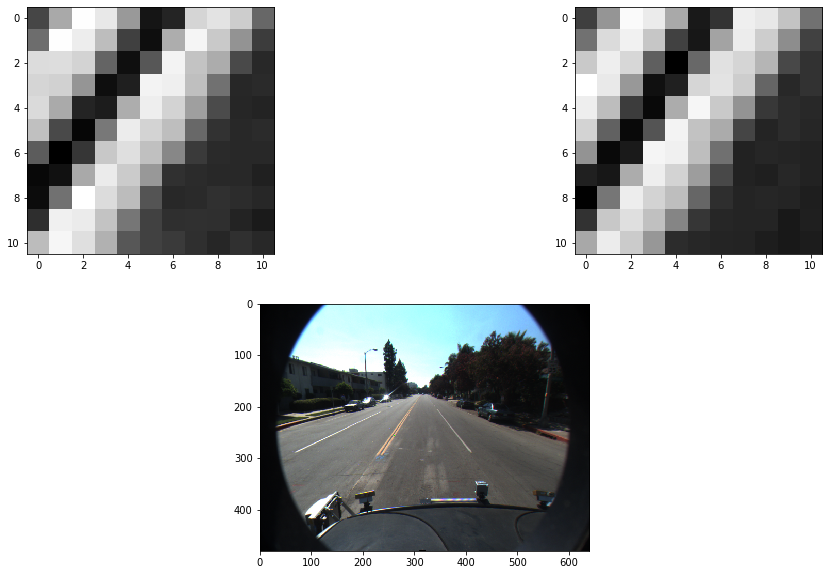

In [55]:
from skimage.draw import line


res_img = np.copy(lane2)
for (x, y), (dx, dy) in store.items():
    rr, cc = line(y, x, y + dy, x + dx)
    res_img[rr, cc] = np.array([0, 255, 0])


fig = plt.figure(figsize=(18, 10))
grid = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[0, 1])
ax3 = fig.add_subplot(grid[1, :])

ax1.imshow(get_window(image, x, y, block_size, shape), cmap='gray')
ax2.imshow(get_window(image, x + dx, y + dy, block_size, shape), cmap='gray')
ax3.imshow(res_img)

None

## Ex. 5.2 Harris Corner Detection
* implement the Harris Corner Detector as discussed in the lecture
* compute corners in the first image and track them with Lucas-Kanade (use e.g. the function "calcOpticalFlowPyrLK" in OpenCV)
* mark the positions of your Harris corners and draw the flow vectors found by Lucas-Kanade on the gray-value versions of the first image (**RESULT**)